# Comprehensive EDA notebook for On-Device Machine Learning for vibration based predictive maintainance of industrial induction motors using MEMS sensors.

### imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import warnings

from scipy.signal import welch, spectrogram
from scipy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from sklearn.manifold import TSNE

### configuration and file loading

In [5]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12,4)

filemap = {
    'motor_off': 'dataset/motor_off.xlsx',
    'motor_on': 'dataset/motor_on.xlsx',
    'motor_on_nofan': 'dataset/motor_on_nofan.xlsx',
    'motor_on_badfan': 'dataset/motor_on_badfan.xlsx'
}
data_columns = ['ax','ay','az','gx','gy','gz']
label_column = 'class_label'
time_column = 'timestamp'
fs = 40.0 #nominal sampling frequency

In [6]:
frames = []

for label,fname in filemap.items():
    df = pd.read_excel(fname)
    frames.append(df)

df = pd.concat(frames)
print ('combined shape:', df.shape)

combined shape: (216000, 7)


In [7]:
df.head()

,ax,ay,az,gx,gy,gz,class_label
0,0.040748,-0.047336,1.006988,-0.7350,-0.0350,-0.3500,0
1,0.042700,-0.050996,1.008696,-0.7525,-0.0175,-0.2975,0
2,0.041724,-0.050996,1.009428,-0.7000,-0.1575,-0.2975,0
3,0.040992,-0.049776,1.008696,-0.6475,-0.1750,-0.2275,0
4,0.038064,-0.051972,1.008208,-0.5950,-0.1750,-0.3500,0


In [8]:
print('------------- dataframe information ---------------')
df.info()

------------- dataframe information ---------------
<class 'pandas.core.frame.DataFrame'>
Index: 216000 entries, 0 to 53999
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ax           216000 non-null  float64
 1   ay           216000 non-null  float64
 2   az           216000 non-null  float64
 3   gx           216000 non-null  float64
 4   gy           216000 non-null  float64
 5   gz           216000 non-null  float64
 6   class_label  216000 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 13.2 MB


In [9]:
print('------------- class distribution ---------------')
print(df[label_column].value_counts())

------------- class distribution ---------------
class_label
0    54000
1    54000
2    54000
3    54000
Name: count, dtype: int64


In [10]:
print('------------- summary statistic ---------------')
print(df[data_columns].describe().T)

------------- summary statistic ---------------
       count      mean        std        min       25%       50%       75%  \
ax  216000.0  0.024923   0.197335  -0.523624 -0.029036  0.014152  0.066856   
ay  216000.0 -0.351560   0.472208  -1.473516 -0.902800 -0.103212 -0.017568   
az  216000.0  0.658866   0.572003  -0.972096  0.192272  0.920124  1.012112   
gx  216000.0 -0.687484  10.536814 -55.877500 -2.922500 -0.665000  1.312500   
gy  216000.0 -0.089271   6.337738 -29.242500 -0.752500 -0.105000  0.752500   
gz  216000.0 -0.273708   2.029743  -9.030000 -0.717500 -0.315000  0.157500   

          max  
ax   1.093120  
ay   0.692716  
az   2.151592  
gx  46.812500  
gy  32.637500  
gz  10.010000  


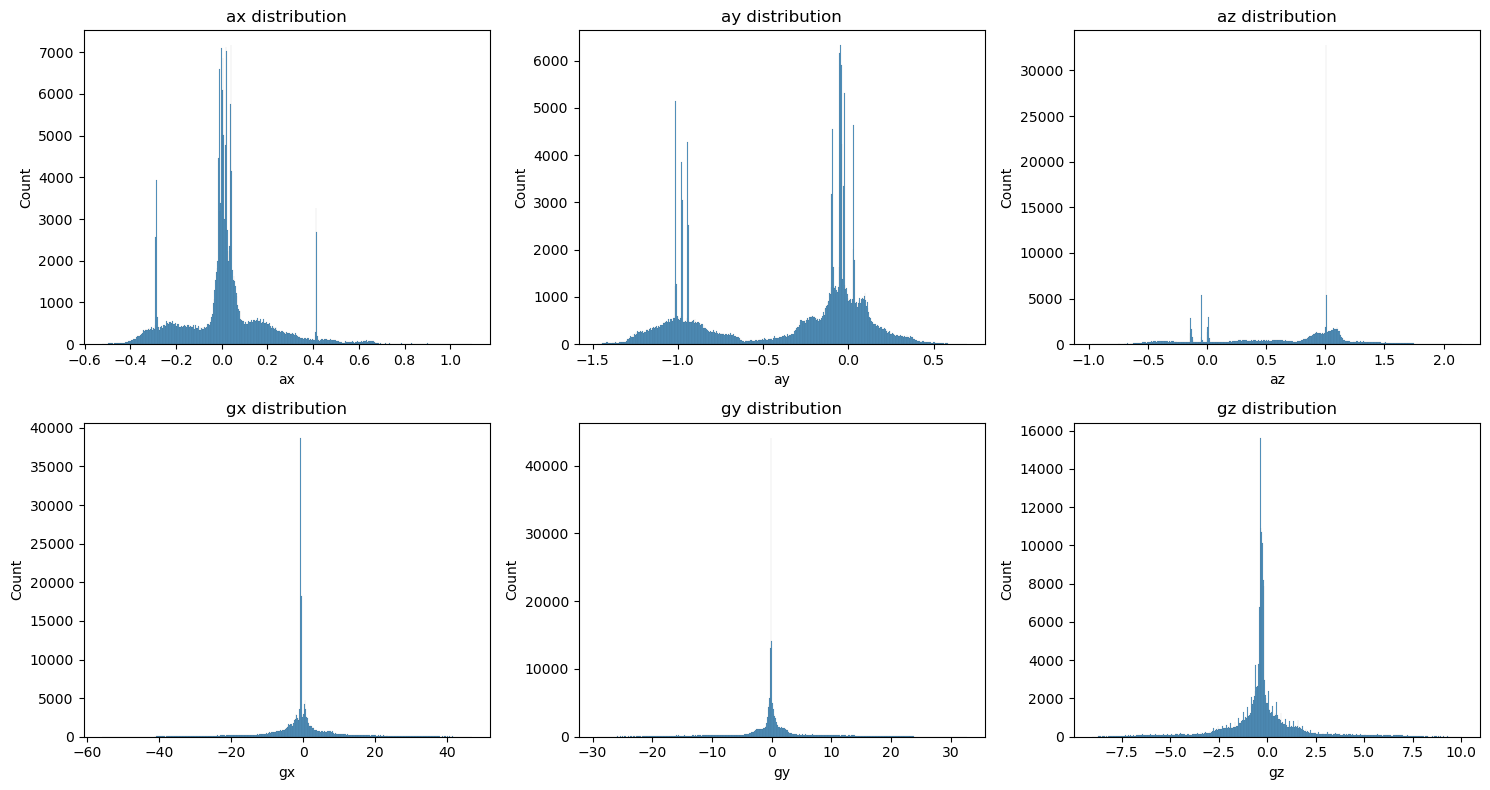

In [11]:
#histogram
fig, axes = plt.subplots(2, 3, figsize = (15,8))

for i, col in enumerate(data_columns):
    ax = axes.flat[i]
    sns.histplot(df[col], bins = 500, ax=ax)
    ax.set_title(f'{col} distribution')

plt.tight_layout()

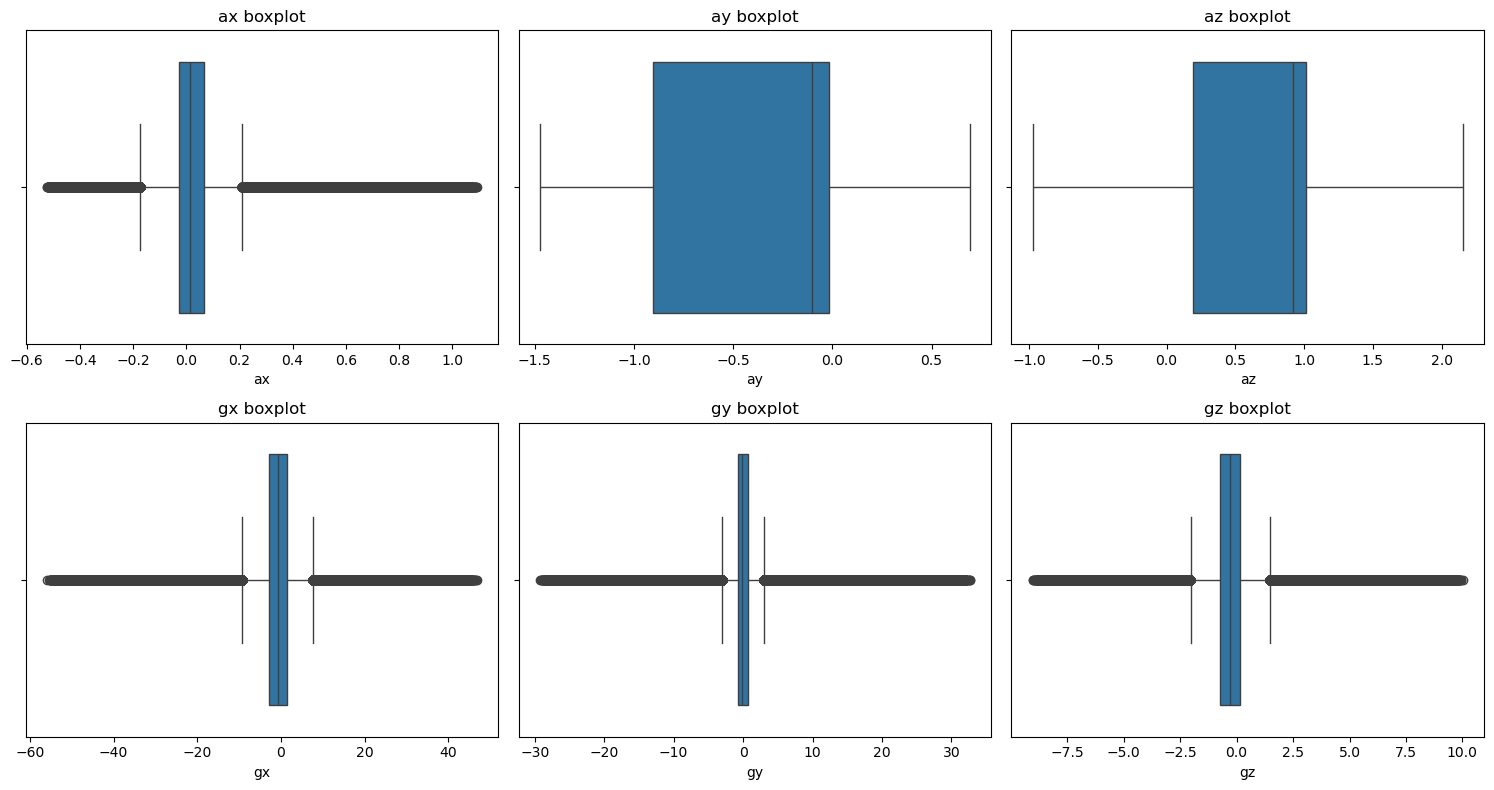

In [12]:
#boxplot
fig, axes = plt.subplots(2, 3, figsize = (15,8))

for i, col in enumerate(data_columns):
    ax = axes.flat[i]
    sns.boxplot(x = df[col], ax = ax)
    ax.set_title(f'{col} boxplot')

plt.tight_layout()

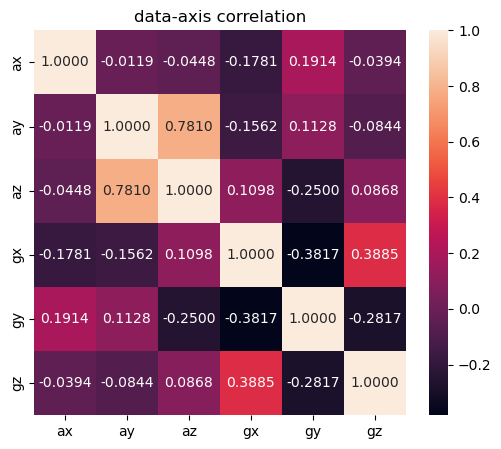

In [13]:
plt.figure(figsize=(6,5))

sns.heatmap(df[data_columns].corr(), annot=True, fmt='.4f')
plt.title('data-axis correlation')
plt.show()

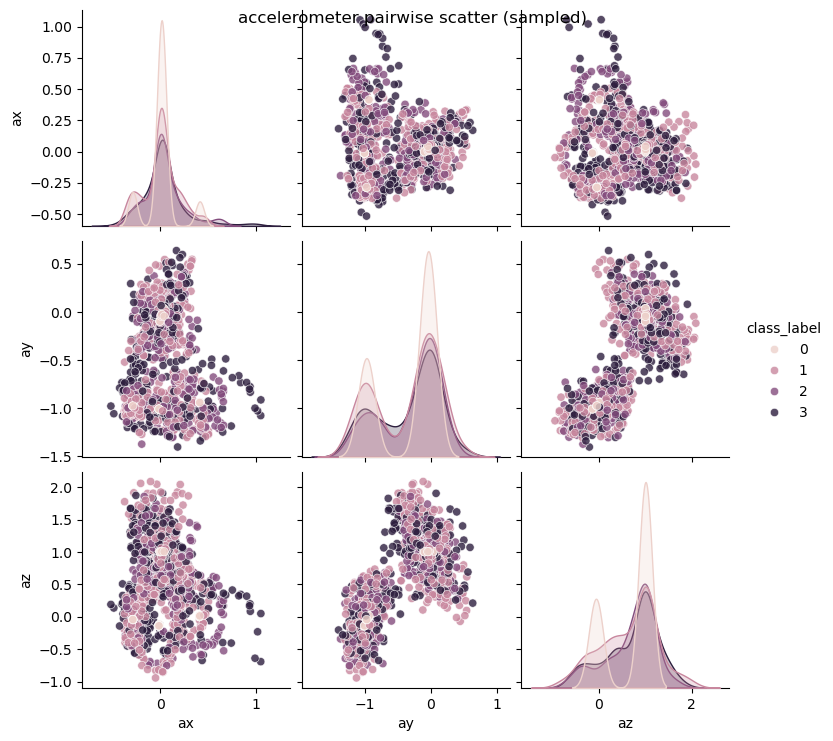

In [14]:
# Scatter pairs for accelerometer axes
sns.pairplot(df.sample(min(2000,len(df))), vars = ['ax','ay','az'], hue = label_column, plot_kws = {'alpha':0.8})
plt.suptitle('accelerometer pairwise scatter (sampled)')
plt.show()

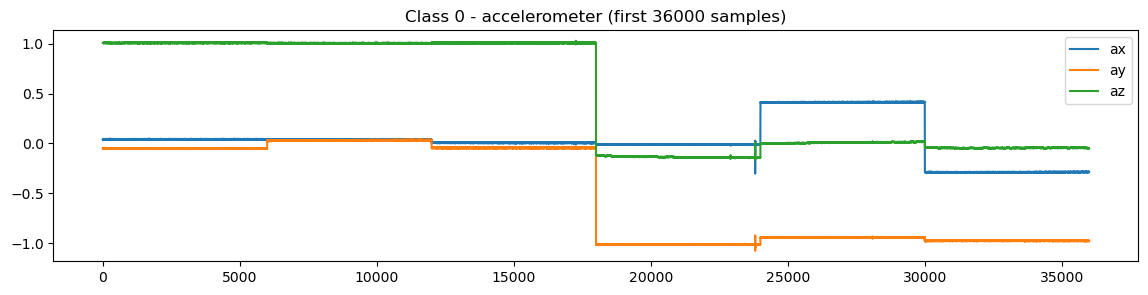

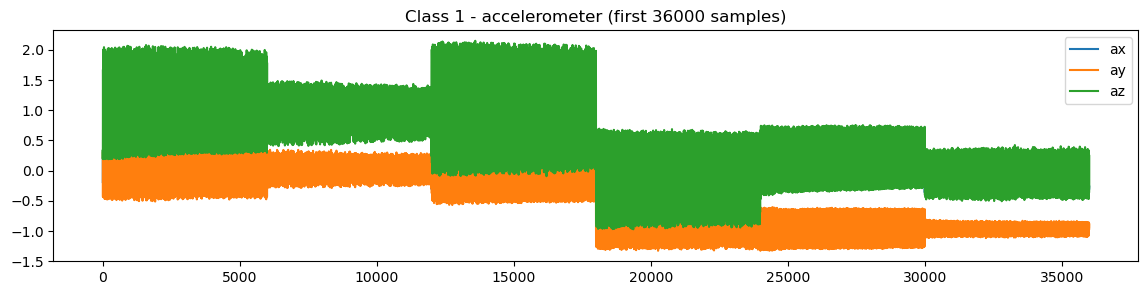

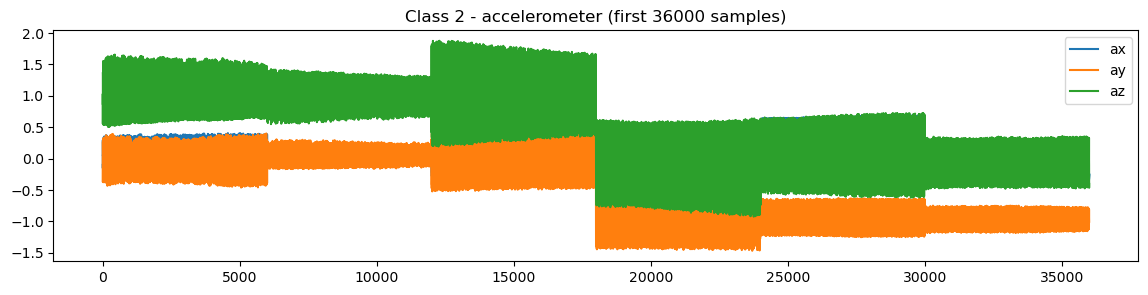

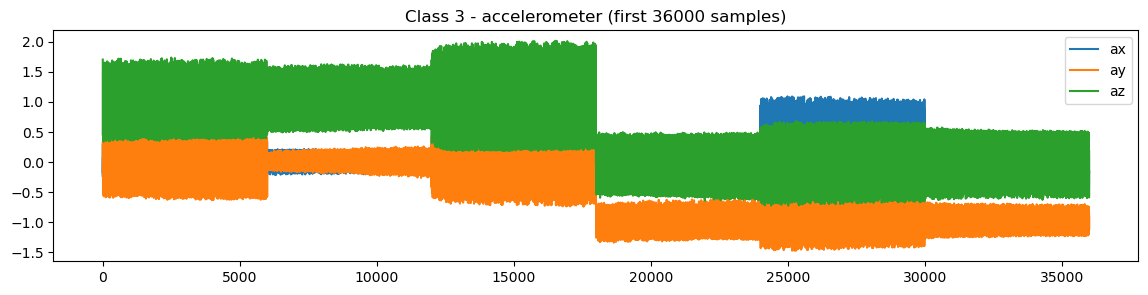

In [15]:
# first N samples for each class to visually compare waveforms
N = 36000

unique_labels = sorted(df[label_column].unique())

for lab in unique_labels:
    sub = df[df[label_column] == lab].head(N)
    plt.figure(figsize = (14,3))
    plt.plot(sub[data_columns[:3]].values)
    plt.legend(data_columns[:3])
    plt.title(f'Class {lab} - accelerometer (first {len(sub)} samples)')
    plt.show()

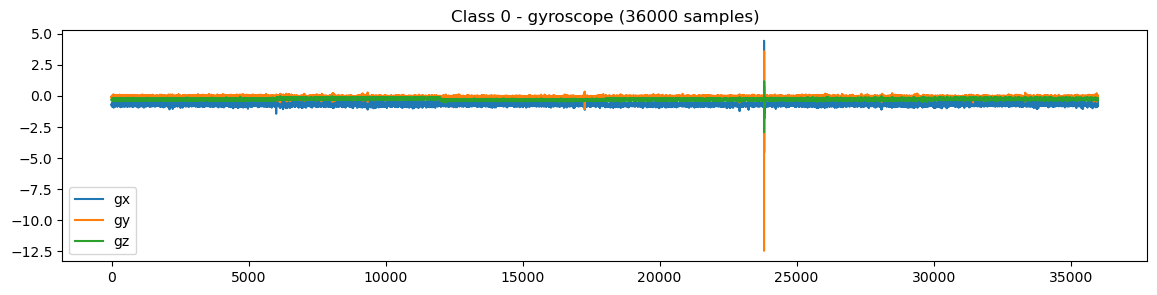

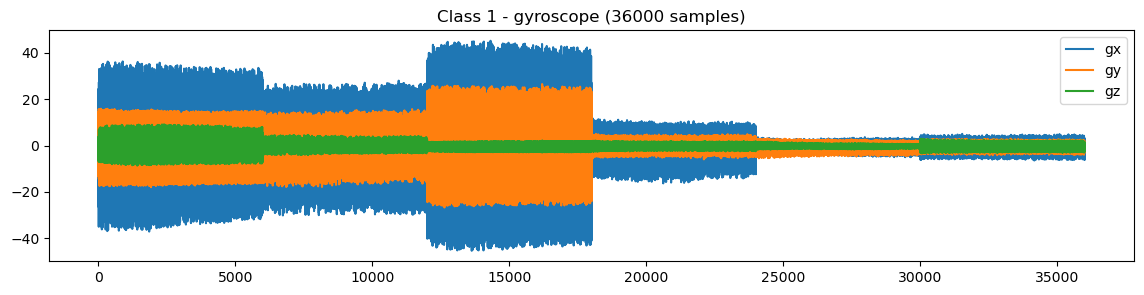

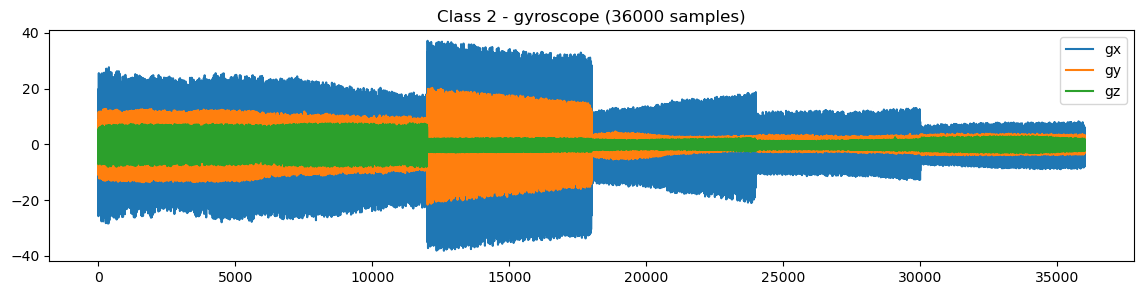

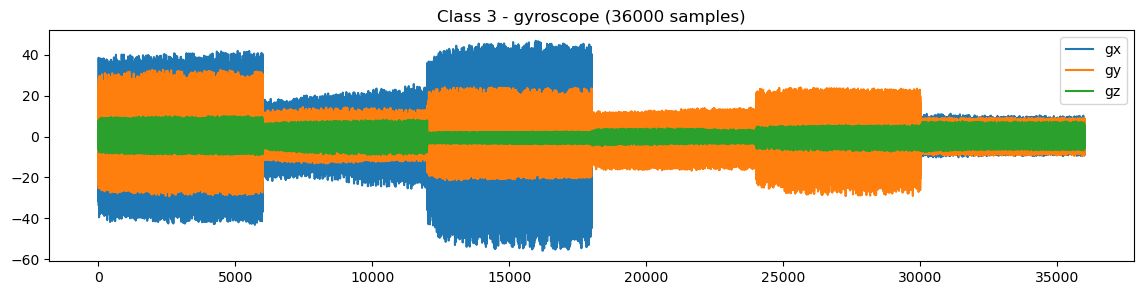

In [16]:
# first N samples for each class to visually compare waveforms
N = 36000

unique_labels = sorted(df[label_column].unique())

for lab in unique_labels:
    sub = df[df[label_column] == lab].head(N)
    plt.figure(figsize = (14,3))
    plt.plot(sub[data_columns[3:7]].values)
    plt.legend(data_columns[3:7])
    plt.title(f'Class {lab} - gyroscope ({len(sub)} samples)')
    plt.show()

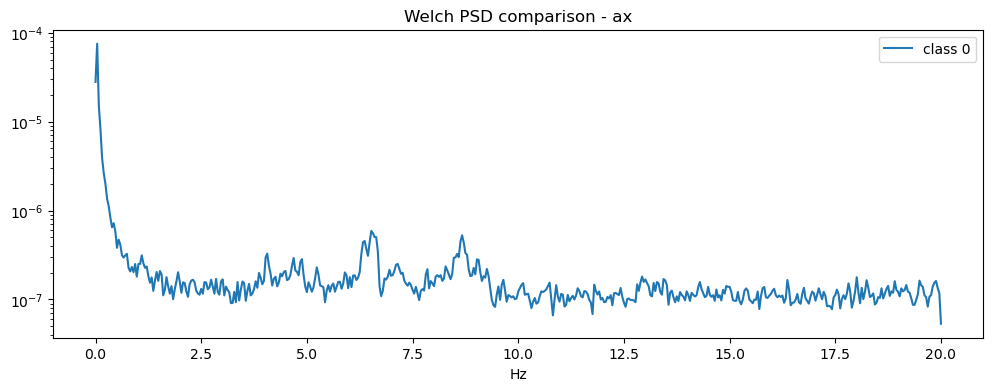

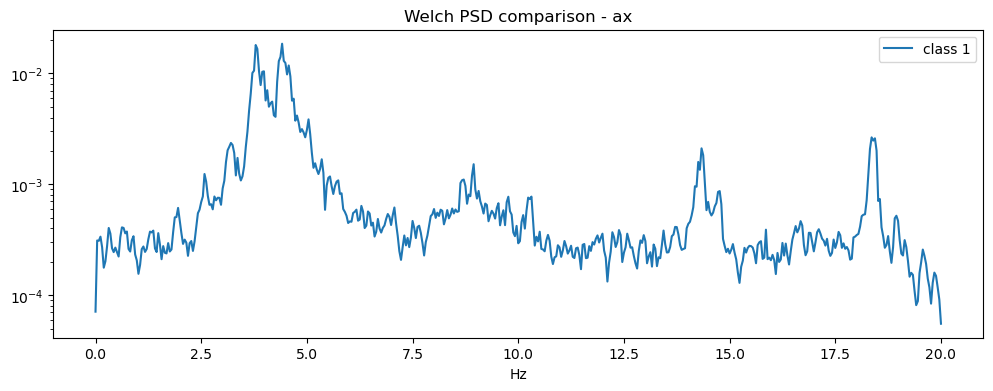

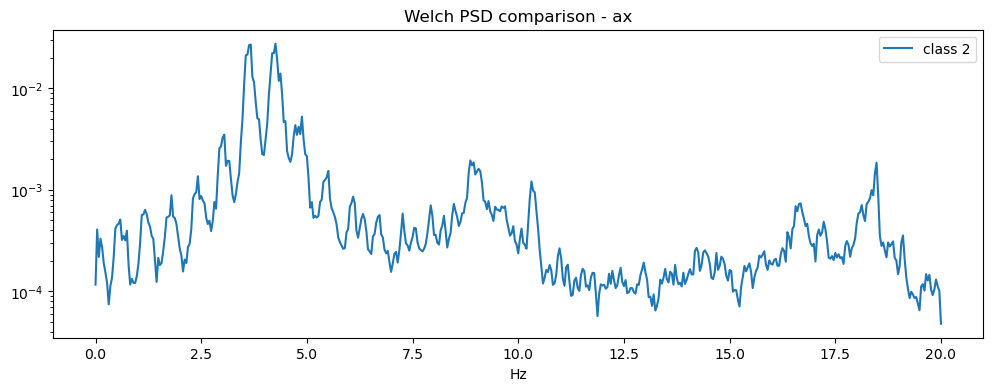

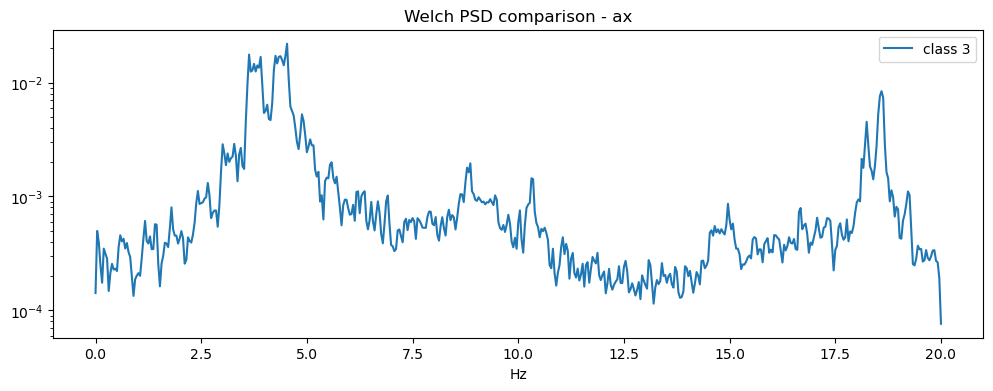

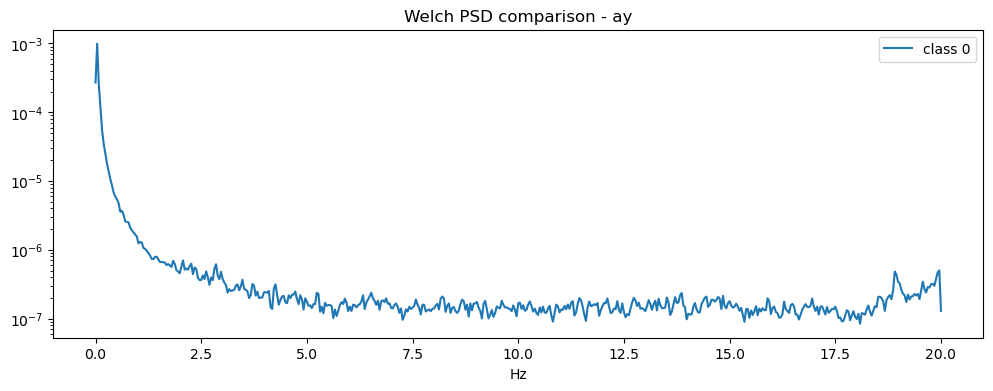

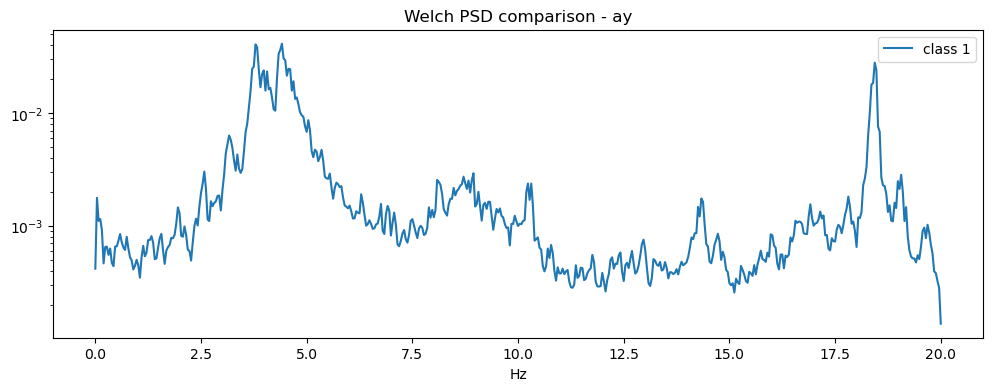

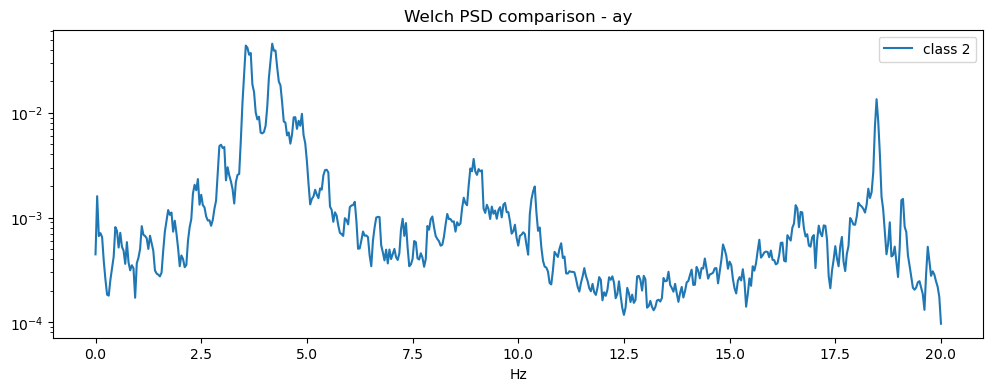

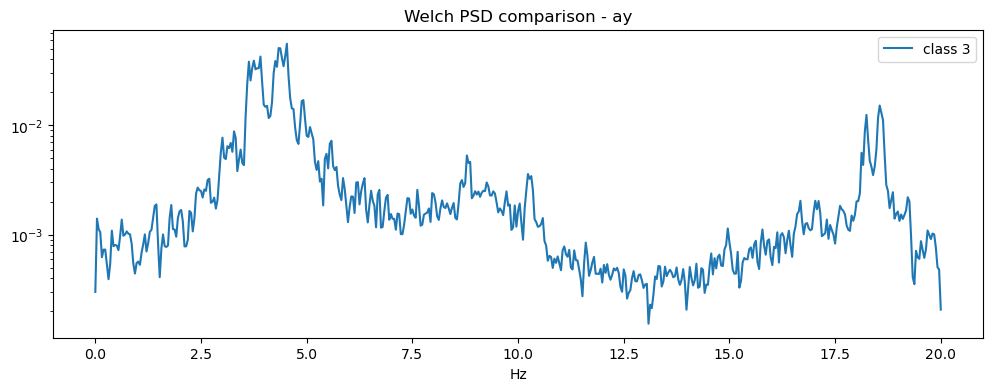

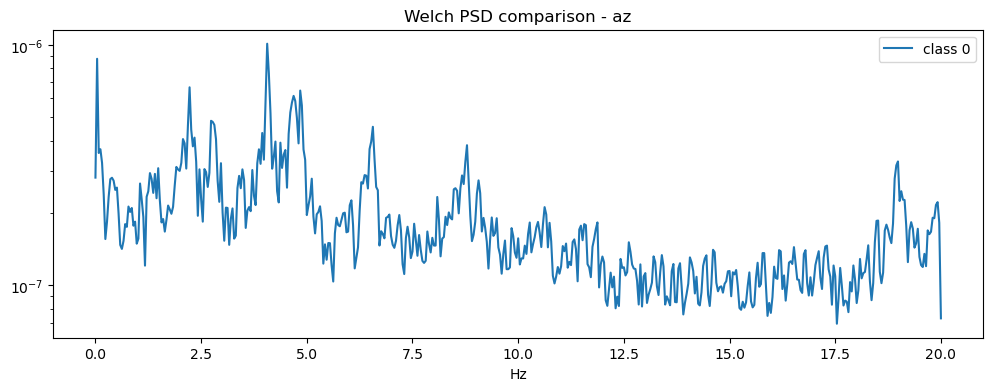

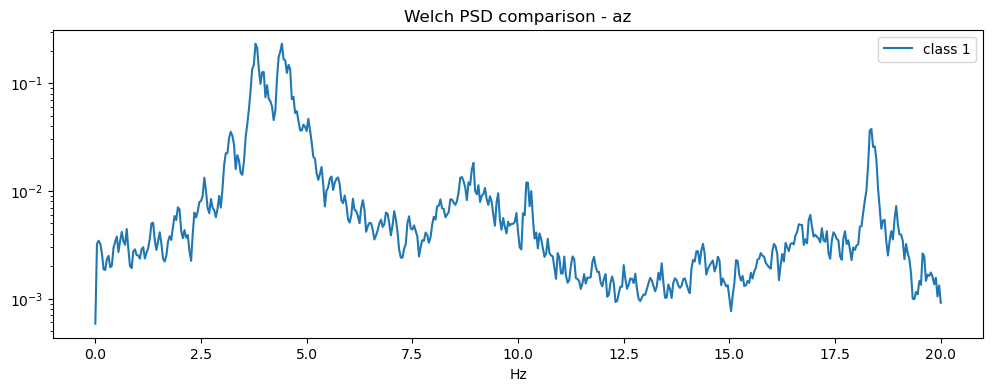

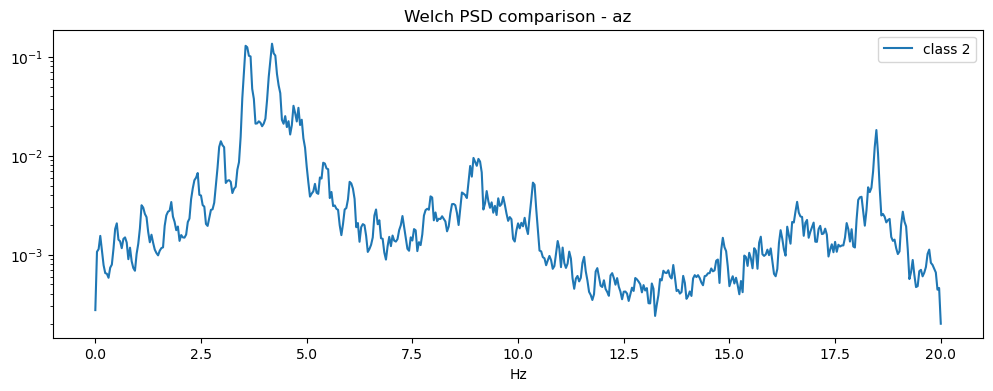

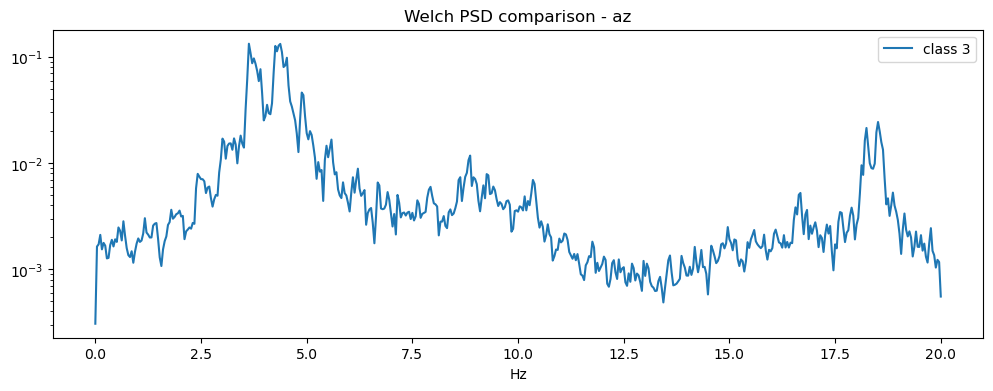

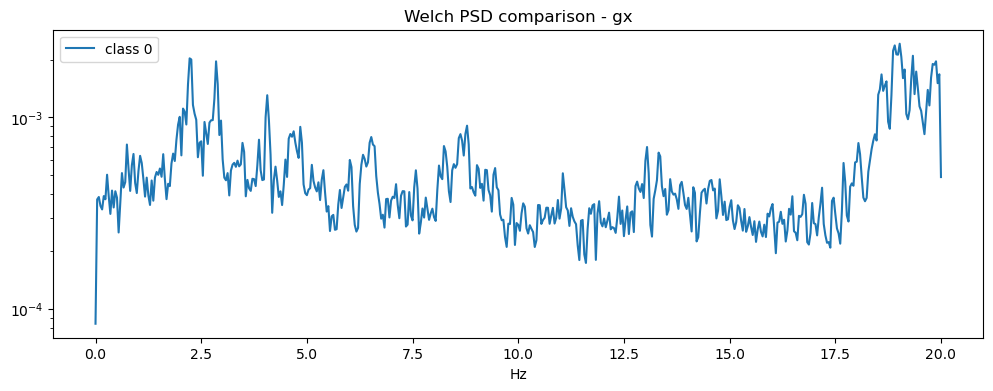

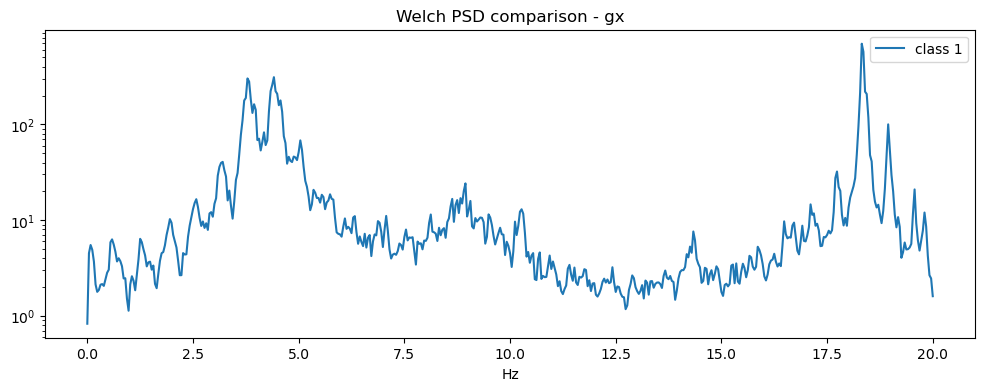

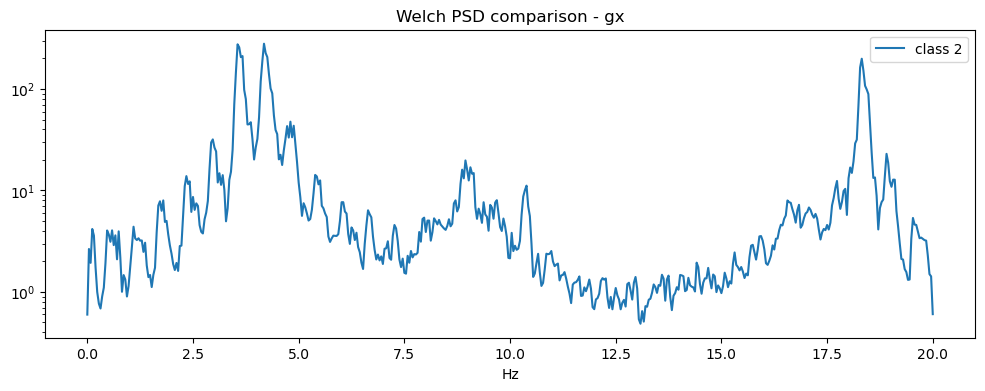

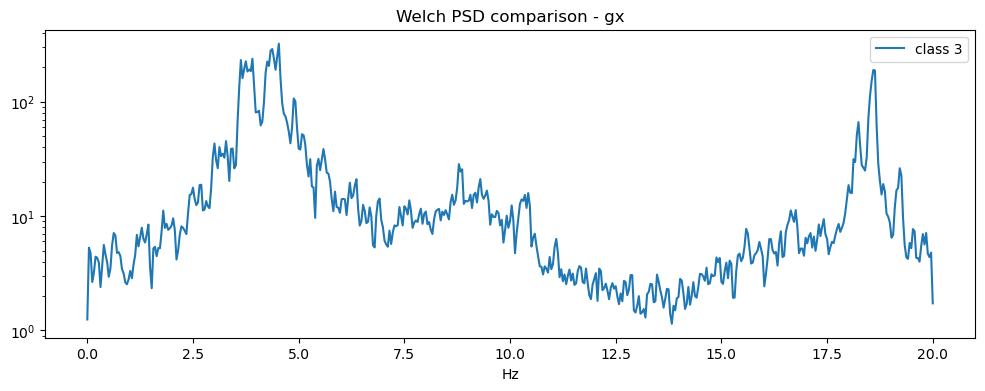

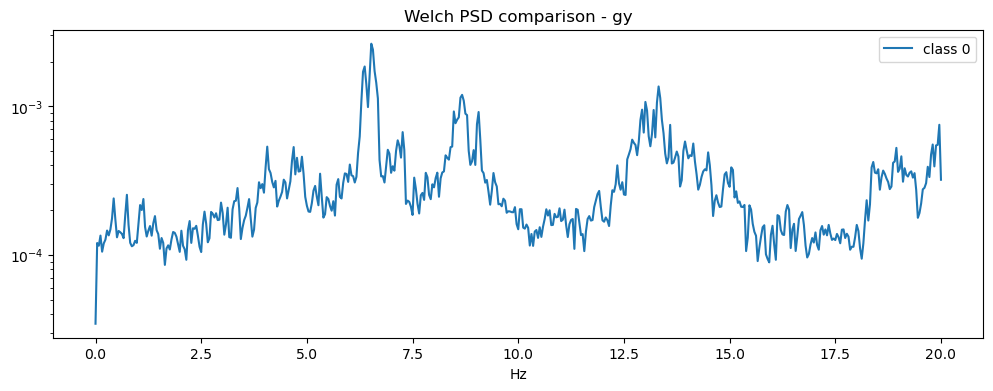

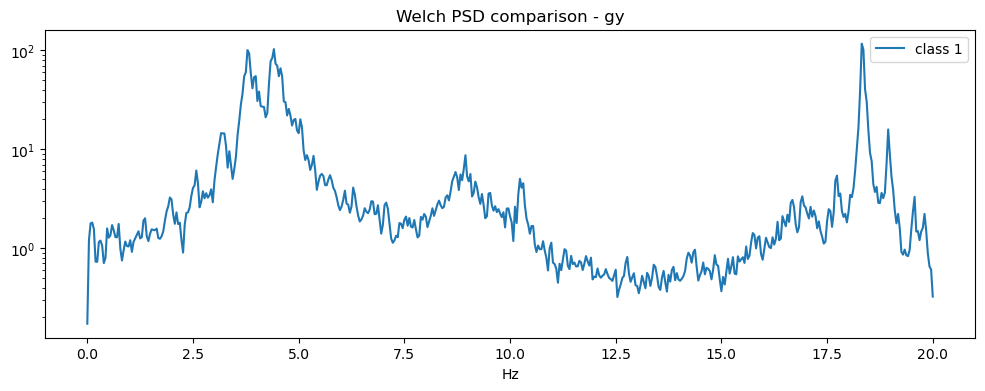

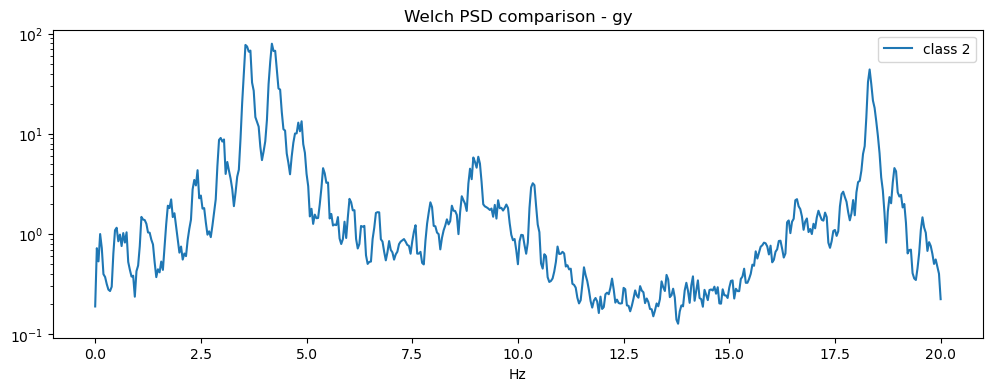

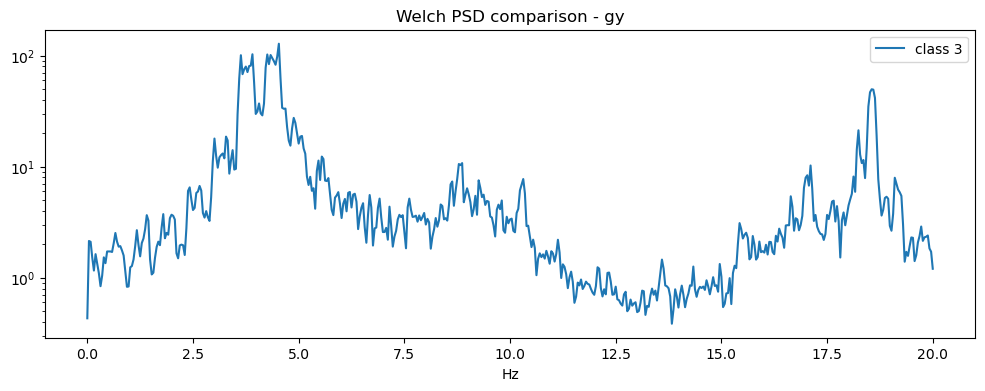

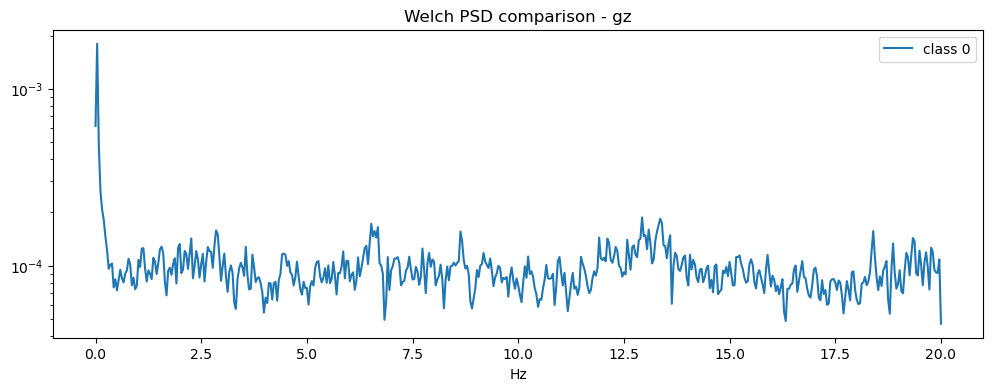

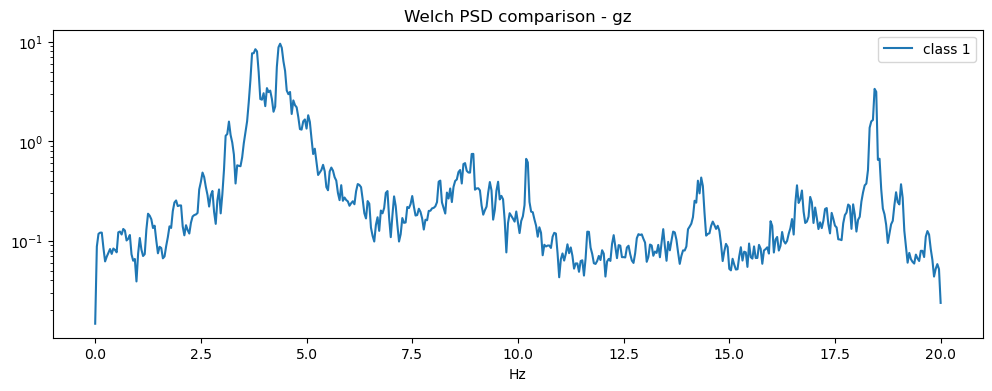

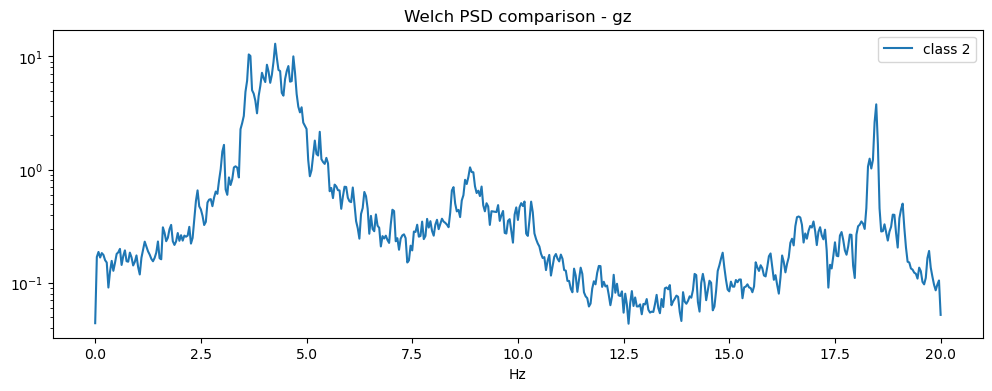

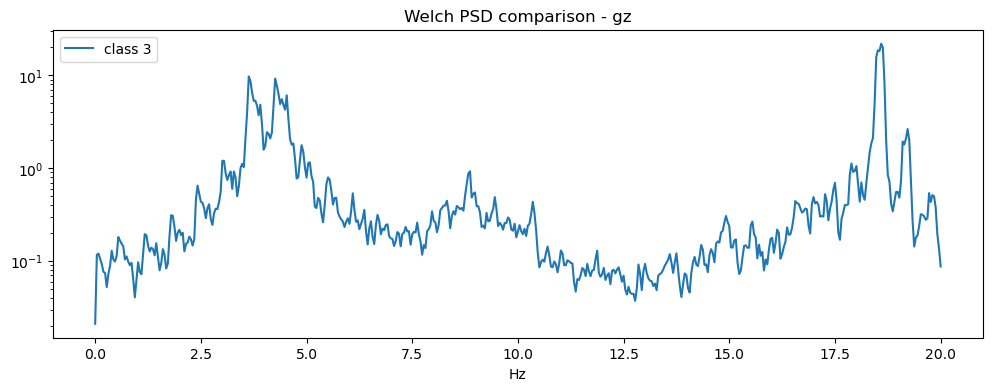

In [17]:
def plot_welch_for_class(df_class, sensor_col, fs, nperseg=512):
    f, Pxx = welch(df_class[sensor_col].values, fs = fs, nperseg=nperseg)
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD'); plt.title(f'Welch PSD - class {df_class[label_column].iloc[0]} - {sensor_col}')

for col in data_columns:
    plt.figure()

    for lab in unique_labels:
        sub = df[df[label_column]==lab]
        
        # use a reasonable subset for speed
        sub_small = sub[col].dropna().values[:16000]
        if len(sub_small) < 128:
            continue
        f, Pxx = welch(sub_small, fs, nperseg=1024)
        plt.semilogy(f, Pxx, label = f'class {lab}')
        plt.legend(); plt.xlabel('Hz'); plt.title(f'Welch PSD comparison - {col}'); plt.show()

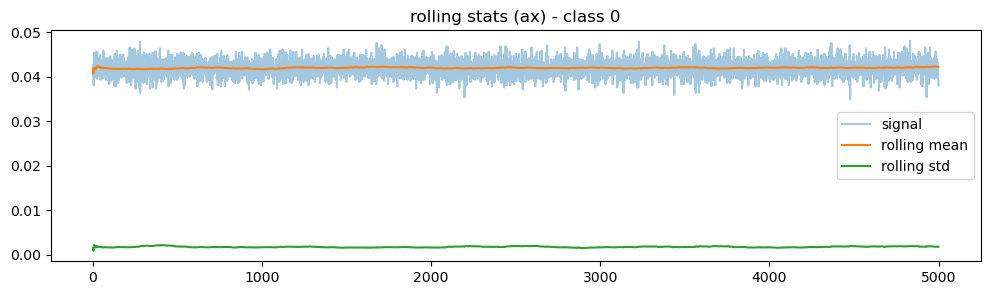

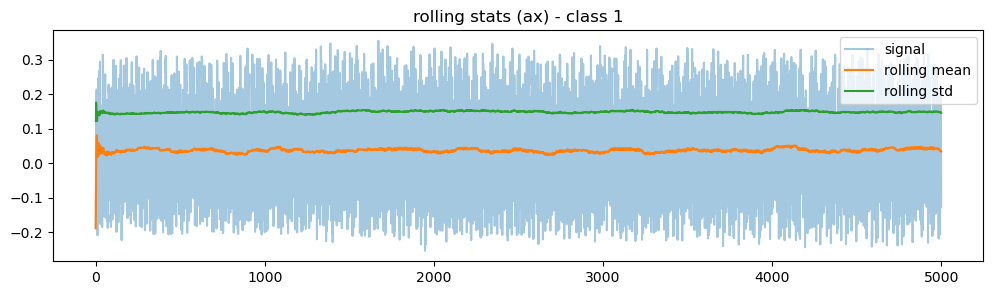

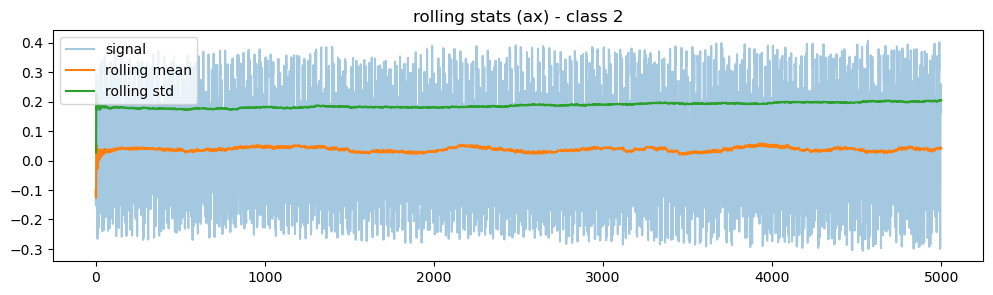

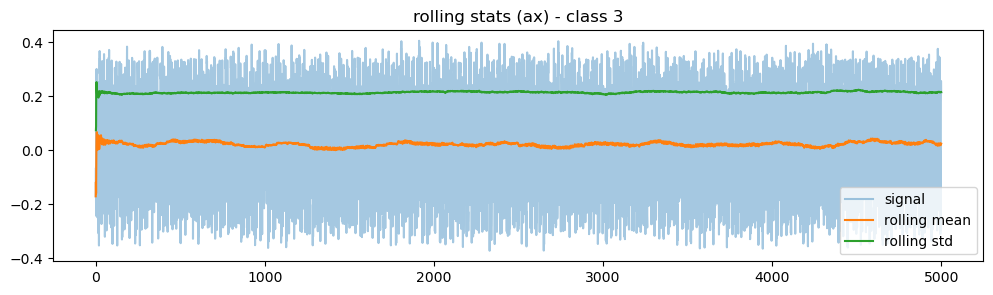

In [18]:
#rolling statistics
window = int(fs * 5) # 5-second rolling window

for lab in unique_labels:
    sub = df[df[label_column] == lab]
    if len(sub) < window:
        continue
    roll_mean = sub['ax'].rolling(window = window, min_periods=1).mean()
    roll_std = sub['ax'].rolling(window = window, min_periods=1).std()
    plt.figure(figsize=(12,3))
    plt.plot(sub['ax'].values[:5000], alpha = 0.4, label='signal')
    plt.plot(roll_mean.values[:5000], label = 'rolling mean')
    plt.plot(roll_std.values[:5000], label = 'rolling std')
    plt.title(f'rolling stats (ax) - class {lab}'); plt.legend(); plt.show()

In [19]:
# spectral entropy (a measure of signal irregularity)

def spectral_entropy(x, fs = fs, nperseg = 256):
    f, Pxx = welch(x, fs = fs, nperseg = nperseg)
    Pxx_norm = Pxx / np.sum(Pxx)
    se = -np.sum(Pxx_norm * np.log(Pxx_norm + 1e-12))
    return se


for lab in unique_labels:
    sub = df[df[label_column] == lab]
    if len(sub) < 1024:
        continue
    se_ax = spectral_entropy(sub['ax'].values[:4096])
    print(f'Class {lab} spectral entropy (ax): {se_ax:.4f}')

Class 0 spectral entropy (ax): 4.6003
Class 1 spectral entropy (ax): 3.6898
Class 2 spectral entropy (ax): 3.4676
Class 3 spectral entropy (ax): 3.6190


embedding matrix shape: (400, 1536)


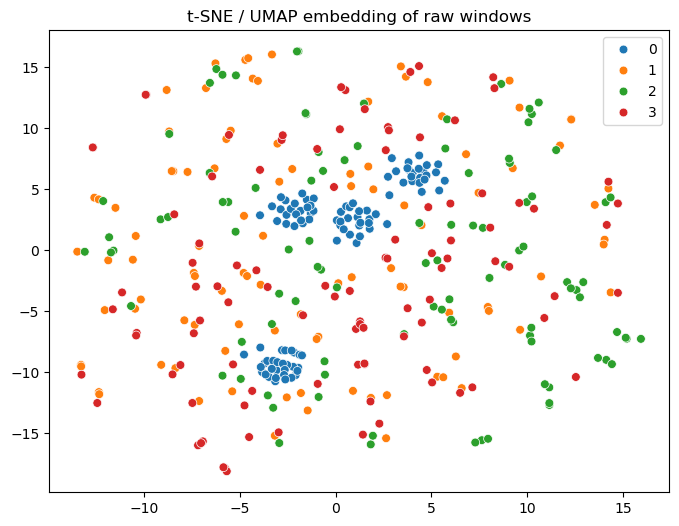

In [20]:
# t-SNE / UMAP embedding of short windows to inspect separability by forming windows (non-overlapping) of size 256 for embedding

try:
    import umap
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False


W = 256

sample_per_class = 100 # windows per class for embedding
windows = []
labels_emb = []

for lab in unique_labels:
    sub = df[df[label_column] == lab]
    n_windows = min(sample_per_class, len(sub)//W)
    
    for i in range(n_windows):
        start = i * W
        win = sub[data_columns].values[start:start+W]
        
        # flatten
        windows.append(win.flatten())
        labels_emb.append(lab)

X_emb = np.array(windows)
print('embedding matrix shape:', X_emb.shape)


if X_emb.shape[0] >= 3:
    if _HAS_UMAP:
        reducer = umap.UMAP(n_components = 2, random_state = 42)
        emb = reducer.fit_transform(X_emb)
    else:
        emb = TSNE(n_components = 2, random_state = 42, init = 'pca', perplexity = 30).fit_transform(X_emb)
        plt.figure(figsize = (8,6))
        sns.scatterplot(x = emb[:,0], y = emb[:,1], hue = labels_emb, palette = 'tab10', s = 40)
        plt.title('t-SNE / UMAP embedding of raw windows'); plt.show()
else:
    print('Not enough windows for embedding.');

### permutation / sanity check

CV Accuracy: 0.646 ± 0.025


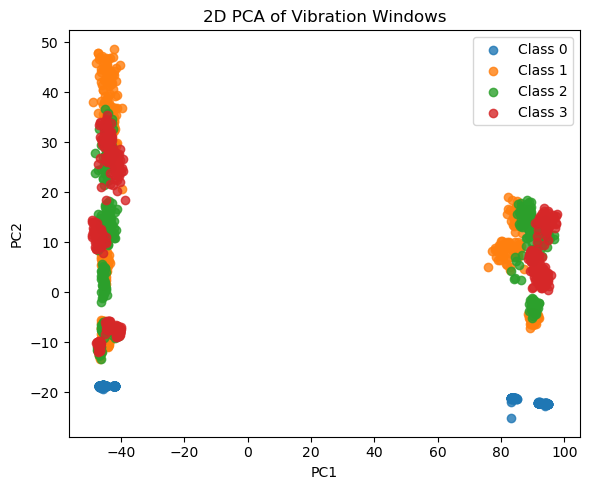

In [22]:
# PCA + Logistic Regression Baseline
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# 1) Reload & re-segment (non-overlap)
files = {
    'motor_off': 'dataset/motor_off.xlsx',
    'motor_on': 'dataset/motor_on.xlsx',
    'motor_on_nofan': 'dataset/motor_on_nofan.xlsx',
    'motor_on_badfan': 'dataset/motor_on_badfan.xlsx'
}
dataframes = {label: pd.read_excel(path) for label, path in files.items()}

def segment_signal(df, window_size=100, step_size=100):
    segs, labs = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        seg = df[['ax','ay','az']].iloc[start:start+window_size].values.T
        segs.append(seg)
        labs.append(df['class_label'].iloc[start])
    return np.array(segs), np.array(labs)

# gather all segments and labels
segments_list, labels_list = [], []
for df in dataframes.values():
    s, l = segment_signal(df)
    segments_list.append(s)
    labels_list.append(l)
segments_all = np.concatenate(segments_list, axis=0)
labels_all   = np.concatenate(labels_list, axis=0)

# 2) Feature extraction (including vector magnitude)
def extract_features_with_magnitude(segs, fft_bins=50, roll_win=10):
    feats = []
    for x, y, z in segs:
        def axis_feats(sig):
            vals = np.abs(fft(sig))[:fft_bins]
            m, s, mn, mx = sig.mean(), sig.std(), sig.min(), sig.max()
            sk, kt = skew(sig), kurtosis(sig)
            rv = pd.Series(sig).rolling(roll_win).var().dropna()
            rv_m, rv_s = rv.mean(), rv.std()
            return np.hstack([vals, m, s, mn, mx, sk, kt, vals.mean(), vals.std(), rv_m, rv_s])
        x_f, y_f, z_f = axis_feats(x), axis_feats(y), axis_feats(z)
        acc = np.sqrt(x**2 + y**2 + z**2)
        a_vals = np.abs(fft(acc))[:fft_bins]
        a_stats = [acc.mean(), acc.std(), acc.min(), acc.max(), skew(acc), kurtosis(acc)]
        a_rv = pd.Series(acc).rolling(roll_win).var().dropna()
        a_feats = np.hstack([a_vals, *a_stats, a_vals.mean(), a_vals.std(), a_rv.mean(), a_rv.std()])
        feats.append(np.hstack([x_f, y_f, z_f, a_feats]))
    return np.array(feats)

features_all = extract_features_with_magnitude(segments_all)

# 3) PCA to 10 components for modeling
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(features_all)

# 4) Logistic Regression with 5-fold Stratified CV
clf = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_pca, labels_all, cv=cv, scoring='accuracy')
print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# 5) PCA to 2 components for scatter plot
pca2 = PCA(n_components=2, random_state=42)
X_vis = pca2.fit_transform(features_all)
df_vis = pd.DataFrame(X_vis, columns=['PC1','PC2'])
df_vis['label'] = labels_all

plt.figure(figsize=(6,5))
for lbl in sorted(df_vis['label'].unique()):
    subset = df_vis[df_vis['label']==lbl]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {lbl}', alpha=0.8)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA of Vibration Windows')
plt.legend()
plt.tight_layout()
plt.show()